# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
# パラメータ設定
n = 100000  # データサイズ
p = 20  # 特徴量数
s = 5  # 非ゼロ係数の数
rho = 0.35  # 相関レベル
snr = 1  # 信号対雑音比
beta_type = "first_large"

RANDOM_STATE = 0  # 乱数シード

N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

In [3]:
def simulate_data(n, p, s, rho, snr, beta_type, seed):
    np.random.seed(seed)

    # # 1. β₀の生成
    beta = np.zeros(p)
    if beta_type == "all_one":
        beta[:s] = 1
    if beta_type == "first_large":
        beta[0] = 3
        beta[1:s] = 0.5

    # 2. 共分散行列Σの生成
    Sigma = np.fromfunction(lambda i, j: rho ** np.abs(i - j), (p, p), dtype=int)

    # 3. Xの生成 (多変量正規分布)
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    # 4. 応答変数Yの生成
    signal_variance = beta @ beta  # β₀の分散
    noise_variance = signal_variance / snr  # ノイズ分散 σ²
    noise = np.random.normal(scale=np.sqrt(noise_variance), size=n)  # ノイズ項
    Y = X @ beta + noise

    return X, Y, beta

In [4]:
X_train, y_train, beta_train = simulate_data(n, p, s, rho, snr, beta_type, seed=0)
X_test, y_test, beta_test = simulate_data(n, p, s, rho, snr, beta_type, seed=1)

In [5]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
### Kmeansのクラスタ数確認

In [6]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[ 9611  9812 10439 10490  9669 10443 10226  9669  9858  9783]


-------------
### Xmeans で確認

##### Xmeans

In [7]:
# def compute_bic(X, kmeans):
#     labels = kmeans.labels_
#     clusters = kmeans.cluster_centers_
#     n_clusters = len(clusters)
#     n = len(X)
#     m = X.shape[1]
#     variance = np.sum(
#         [
#             np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
#             for i in range(n_clusters)
#         ]
#     )
#     bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
#     return bic


# def xmeans(X, k_min=2, k_max=10):
#     kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
#     kmeans.fit(X)
#     best_bic = compute_bic(X, kmeans)
#     best_k = k_min
#     score_dict = {}
#     score_dict[k_min] = best_bic
#     for k in range(k_min + 1, k_max + 1):
#         kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
#         kmeans.fit(X)
#         current_bic = compute_bic(X, kmeans)
#         score_dict[k] = current_bic
#         if current_bic < best_bic:
#             best_bic = current_bic
#             best_k = k
#     return best_k, score_dict

##### クラスタリング結果

In [8]:
# best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
# print("n_clusters chosen in Xmeans:", best_k)

# x = []
# for k in score_dict.keys():
#     x.append(str(k))
# y = [score for score in score_dict.values()]
# bars = plt.bar(x, y)
# plt.ylabel("BIC", fontsize=30)
# plt.xlabel("Number of clusters", fontsize=30)
# plt.tick_params(axis="both", which="major", labelsize=25)
# plt.tight_layout()
# plt.show()

-----------------------------
### シルエット係数で確認

In [9]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

n_clusters chosen: 2


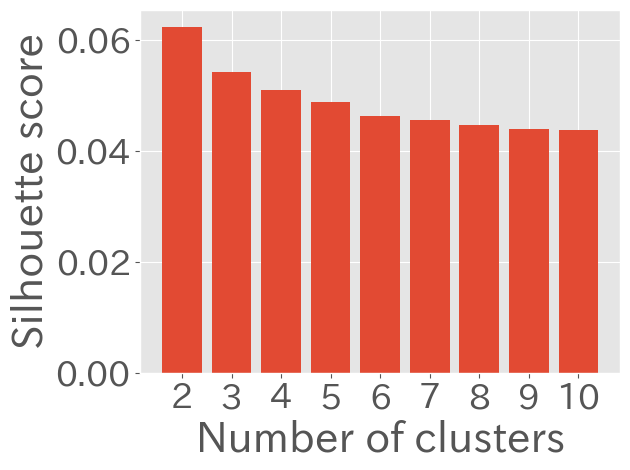

In [10]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [11]:
print(score_dict)

{2: 0.06227907420048894, 3: 0.05429927286688279, 4: 0.05091613340037481, 5: 0.04874847773136787, 6: 0.04632544681920753, 7: 0.04552842510255603, 8: 0.044665455728344586, 9: 0.043993025373742736, 10: 0.043756901424155246}


### シルエット図

In [12]:
# def plot_silhouette_diagram(n_clusters: int, X):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
#     labels = kmeans.fit_predict(X)
#     cluster_labels = np.unique(labels)
#     n_clusters = cluster_labels.shape[0]

#     silhouette_vals = silhouette_samples(X, labels, metric="euclidean")
#     y_ax_lower, y_ax_upper = 0, 0
#     yticks = []

#     for i, c in enumerate(cluster_labels):
#         c_silhouette_vals = silhouette_vals[labels == c]
#         c_silhouette_vals.sort()
#         y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(float(i) / n_clusters)
#         plt.barh(
#             range(y_ax_lower, y_ax_upper),
#             c_silhouette_vals,
#             height=1.0,
#             edgecolor="none",
#             color=color,
#         )
#         yticks.append((y_ax_lower + y_ax_upper) / 2.0)
#         y_ax_lower += len(c_silhouette_vals)

#     silhouette_avg = np.mean(silhouette_vals)
#     plt.axvline(silhouette_avg, color="red", linestyle="--")
#     plt.yticks(yticks, cluster_labels + 1)
#     plt.ylabel("Cluster", fontsize=30)
#     plt.xlabel("Silhouette coefficient", fontsize=30)
#     plt.tick_params(axis="both", which="major", labelsize=25)
#     plt.xlim(-0.6, 0.6)
#     plt.tight_layout()
#     plt.show()


In [13]:
# for n_clusters in range(K_MIN, K_MAX + 1):
#     plot_silhouette_diagram(n_clusters=n_clusters, X=X_train_std)


-----
## エルボー図

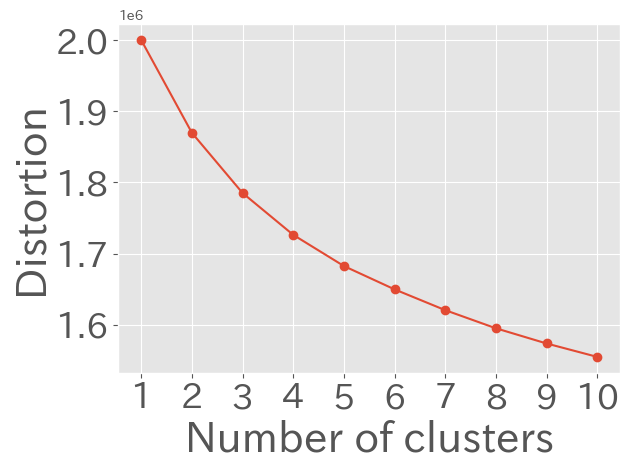

In [14]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()